# Variable jitter

The RV dispersion is typically larger in more active stars. 

To account for this, [Díaz et al.
(2016)](http://dx.doi.org/10.1051/0004-6361/201526729) proposed a model where
the 'jitter' term depends on the value of the $\log R'_{HK}$ indicator. Using
the same notation as in the [models](/docs/models) page, this changes the
default model in **kima** from

$$
v_i \sim \mathcal{N} \left( v_{sys} \,,\: j^2+\sigma_i^2 \right)
$$

to something like

$$
v_i \sim \mathcal{N} \left( v_{sys} \,,\: j^2 + (\alpha_j \cdot {\rm RHK})^2 + \sigma_i^2 \right)
$$


where ${\rm RHK}$ represents the values of $\log R'_{HK}$ normalized to the range $[0-1]$.

<div class="admonition note">
    <div class="admonition-title">Note</div>
    <p style="margin-top: 1em">
        The $\log R'_{HK}$ values are normalized to $[0-1]$
        by subtracting the minimun value and dividing by the peak-to-peak.
        This means that the additional white noise at the minimum $\log R'_{HK}$ value is zero.
    </p>
</div>

The parameter $\alpha_j$ is unknown and represents the slope of the dependence
of the jitter with $\log R'_{HK}$. We may assume that $\alpha_j>0$ always. This
model is implemented in [RVmodel](/docs/API/kima#RVmodel) with the
`jitter_propto_indicator` setting. 

Let's see an example.

### Simulating a dataset

First, we get some standard imports out of the way

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kima
from kima import keplerian

We'll generate a simple RV dataset that contains only noise. At the same time,
we also generate fake $\log R'_{HK}$ values which first increase slightly and
then decrease. This simulates the variation that could be observed due to a
stellar magnetic cycle.

In [4]:
def create_data(multiple_instruments=False):
    np.random.seed(43)  # to be reproducible

    # random times over a short timespan
    t = np.sort(np.random.uniform(0, 100, 87))

    # RVs with only white noise and associated uncertainties
    rv = np.random.normal(loc=-3, scale=0.01, size=t.size)
    err_rv = np.random.uniform(0.1, 0.4, t.size)

    # simulate log R'HK (using a Keplerian function just for convenience)
    rhk = -4.9 + np.array(keplerian(t, 300, 0.1, 0.5, 0.0, 0, 60))
    rhk += np.random.normal(loc=0.0, scale=3e-3, size=t.size)
    err_rhk = np.random.uniform(4e-3, 6e-3, t.size)

    # normalize to range [0, 1]
    norm_rhk = (rhk - rhk.min()) / np.ptp(rhk)

    # to simulate multiple instruments, add an RV offset to some points
    mask = None
    if multiple_instruments:
        mask = np.arange(t.size) > 2 *t.size // 3
        rv[mask] += 2.5

    # !!! add jitter proportional to (normalized) log R'HK !!!
    alpha = 2.1
    rv += np.random.normal(loc=0, scale=alpha * norm_rhk, size=t.size)

    # save the data in text files
    kw = dict(fmt='%10.5f', header='t rv err_rv rhk err_rhk')
    if multiple_instruments:
        D1 = np.c_[
            t[~mask], rv[~mask], err_rv[~mask], rhk[~mask], err_rhk[~mask]
        ]
        D2 = np.c_[
            t[mask], rv[mask], err_rv[mask], rhk[mask], err_rhk[mask]
        ]
        np.savetxt('data1.txt', D1, **kw)
        np.savetxt('data2.txt', D2, **kw)
    else:
        D = np.c_[t, rv, err_rv, rhk, err_rhk]
        np.savetxt('data.txt', D, **kw)
    
    return t, rv, err_rv, rhk, err_rhk, mask

Let's call the function and visualize the data

In [6]:
t, rv, err_rv, rhk, err_rhk, mask = create_data()

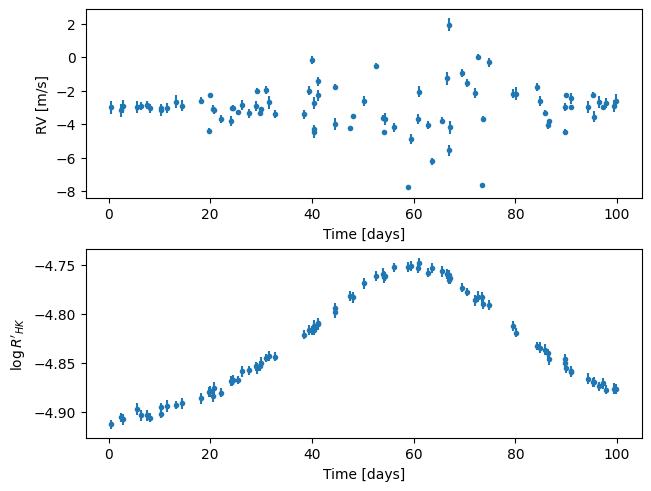

In [7]:
fig, axs = plt.subplots(2, 1, constrained_layout=True)
axs[0].errorbar(t, rv, err_rv, fmt='o', ms=3)
axs[1].errorbar(t, rhk, err_rhk, fmt='o', ms=3)
axs[0].set(xlabel='Time [days]', ylabel='RV [m/s]');
axs[1].set(xlabel='Time [days]', ylabel=r"$\log R'_{HK}$");

As we wanted, the variance of the RVs depends (linearly) on the $\log R'_{HK}$.
For the case of multiple instruments, the data looks very similar, except for
the added RV offset:

In [8]:
t, rv, err_rv, rhk, err_rhk, mask = create_data(multiple_instruments=True)

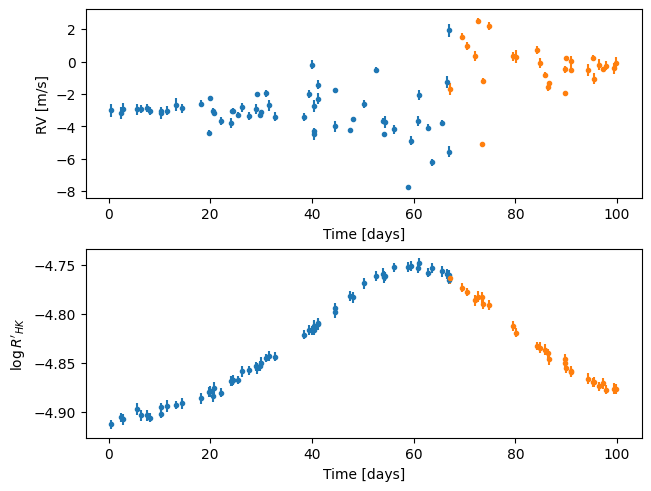

In [9]:
fig, axs = plt.subplots(2, 1, constrained_layout=True)
axs[0].errorbar(t[~mask], rv[~mask], err_rv[~mask], fmt='o', ms=3)
axs[0].errorbar(t[mask], rv[mask], err_rv[mask], fmt='o', ms=3)
axs[1].errorbar(t[~mask], rhk[~mask], err_rhk[~mask], fmt='o', ms=3)
axs[1].errorbar(t[mask], rhk[mask], err_rhk[mask], fmt='o', ms=3)
axs[0].set(xlabel='Time [days]', ylabel='RV [m/s]');
axs[1].set(xlabel='Time [days]', ylabel=r"$\log R'_{HK}$");

<div class="admonition note">
    <div class="admonition-title">Note</div>
    <p style="margin-top: 1em">
        With this very simple simulation, we are trying to reproduce the observed data of active stars.
        For example, compare the above with Fig. 9 from
        <a href="http://dx.doi.org/10.1051/0004-6361/201526729/">Díaz et al.(2016)</a>,
        showing HARPS data for HD40307:
    </p>
    <center>
    <img src="https://www.aanda.org/articles/aa/full_html/2016/01/aa26729-15/aa26729-15-fig9.jpg"
         style="width: 300px; height: 260px; object-fit: cover; object-position: 0 0;"
    />
    </center>
</div>

### A model with fixed jitter

Let's now fit these data, assuming the usual model with a fixed jitter value

In [10]:
from kima import RVData, RVmodel, distributions

data = RVData('data.txt')
model = RVmodel(fix=True, npmax=0, data=data)

Run the model for a few thousand steps

In [11]:
%%time
kima.run(model, steps=5000, num_threads=4)

CPU times: total: 4.95 s
Wall time: 3.63 s


and load the results

In [12]:
res1 = kima.load_results(model)

log(Z) = -158.41
Information = 5.34 nats
BMD = 2.06
Effective sample size = 491.0


100%|██████████| 491/491 [00:00<00:00, 21895.27it/s]


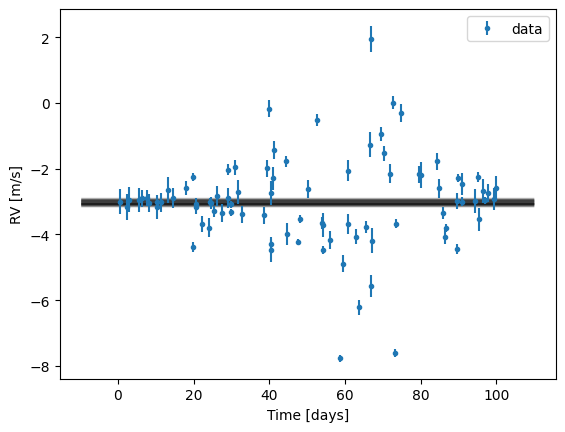

In [13]:
res1.plot_random_samples();

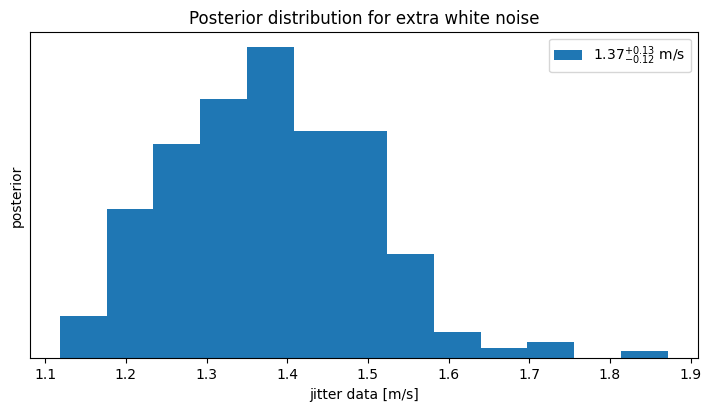

In [14]:
res1.hist_jitter();

### Jitter proportional to $\log R'_{HK}$

Now we run a model where the jitter is proportional to it.

In [15]:
data = RVData('data.txt', indicators=['rhk', 'err_rhk'])
model = RVmodel(fix=True, npmax=0, data=data)
model.jitter_propto_indicator = True

In [16]:
%%time
kima.run(model, steps=5000, num_threads=4)

CPU times: total: 6.53 s
Wall time: 3.84 s


In [17]:
res2 = kima.load_results(model)

log(Z) = -126.71
Information = 10.09 nats
BMD = 3.03
Effective sample size = 623.7


100%|██████████| 623/623 [00:00<00:00, 27750.59it/s]


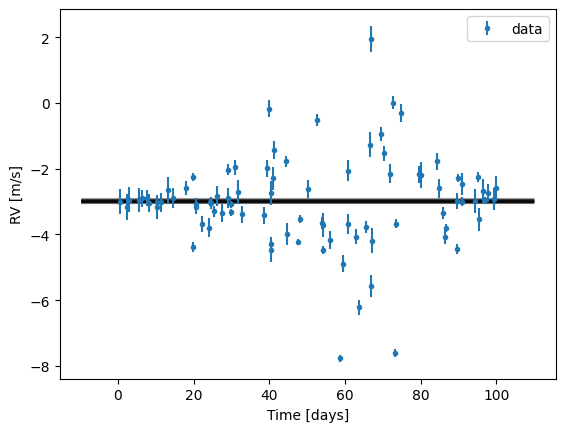

In [18]:
res2.plot_random_samples();

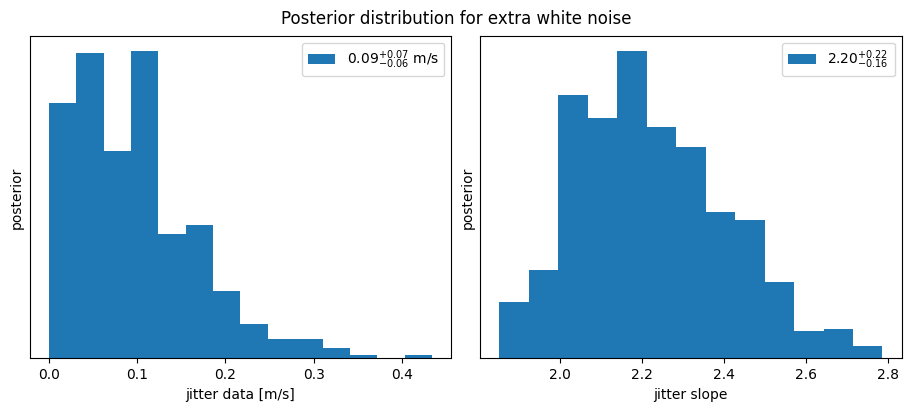

In [19]:
res2.hist_jitter();

Doing model comparison it looks like the second model is indeed a much better
description of the data:

In [27]:
print(f'lnZ model 1: {res1.evidence}')
print(f'lnZ model 2: {res2.evidence}')

lnZ model 1: -158.4087102649185
lnZ model 2: -126.71029077297631


### HARPS data for HD40307

<div class="admonition warning">
    <div class="admonition-title">TODO</div>
</div>